# Rainfall Prediction in Australia


* **Variable Dictionary:**


Variable | Description
---------|------------
Date   |  The date of observation
Location   |  The common name of the location of the weather station
MinTemp   |  The minimum temperature in degrees celsius
MaxTemp   |  The maximum temperature in degrees celsius
Rainfall   |  The amount of rainfall recorded for the day in mm
Evaporation   |  The so-called Class A pan evaporation (mm) in the 24 hours to 9am
Sunshine   |  The number of hours of bright sunshine in the day.
WindGustDir   |  The direction of the strongest wind gust in the 24 hours to midnight
WindGustSpeed   |  The speed (km/h) of the strongest wind gust in the 24 hours to midnight
WindDir9am   |  Direction of the wind at 9am
WindDir3pm   |  Direction of the wind at 3pm
WindSpeed9am   |  Wind speed (km/hr) averaged over 10 minutes prior to 9am
WindSpeed3pm   |  Wind speed (km/hr) averaged over 10 minutes prior to 3pm
Humidity9am   |  Humidity (percent) at 9am
Humidity3pm   |  Humidity (percent) at 3pm
Pressure9am   |  Atmospheric pressure (hpa) reduced to mean sea level at 9am
Pressure3pm   |  Atmospheric pressure (hpa) reduced to mean sea level at 3pm
Cloud9am   |  Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
Cloud3pm | Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
Temp9am |  Temperature (degrees C) at 9am
Temp3pm |  Temperature (degrees C) at 3pm
Precipitation9am |  The amount of rain in mm prior to 9am
Precipitation3pm |  The amount of rain in mm prior to 3pm
AmountOfRain |  The amount of rain in mm
Temp |  Temperature (degrees C)
Humidity |  Humidity (percent)
RainToday |  Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
RainTomorrow |  The target variable. Did it rain tomorrow?

# 1. Importing Modules & Files

## 1.1 Modules

In [111]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

# mlxtend
from mlxtend.plotting import plot_decision_regions

# Yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.features.pca import PCADecomposition

# xgboost
from xgboost import XGBClassifier

import lightgbm as lgb


## 1.2 Rainfall & Wind Files

In [2]:
# Rain parameters
files = sorted(os.listdir('Data'))
rain = pd.read_csv(f'Data/{files[0]}')

In [3]:
# Wind parameters
wind = []
for file in files:
    if file.startswith('w'):
        colnames = ['date','location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
        df = pd.read_csv(f'Data/{file}', names = colnames)
        wind.append(df)
wind = pd.concat(wind, sort=False)

In [4]:
wind.drop(wind.index[0], inplace = True)

## 1.3 Aggregating "Territory" Info from Wikipedia

In [5]:
# Retrieving html from table in wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Australia_by_population'
html = requests.get(url).content
soup = BeautifulSoup(html, 'lxml')
table = soup.find_all('table', attrs={'class':'wikitable sortable plainrowheaders'})[0]

In [6]:
# Finding and selecting desired table
headers = [header.text.strip() for header in table.find_all('th')]
data = [data.text.strip() for data in table.find_all('td')]
nrows = int(len(data)/7)
ncols = 7

In [7]:
# Creating dataframe (city-state/territory)
aus_state = pd.DataFrame(np.array(data).reshape((nrows, ncols)), columns=headers)
aus_state.drop(['Rank', 'June 2018[2]', '2011 Census[3]\nPopulation', 'Growth', 'Percentage ofnational population (June 2018)'], axis=1, inplace = True)
aus_state.rename(columns = {'GCCSA/SUA' : 'location', 'State/Territory' : 'territory'}, inplace = True)

In [8]:
# Merging states/territories into rain df
rain = pd.merge(rain, aus_state, how = 'left', on = 'location')

In [9]:
# Info from Wikipedia table does not include all cities we have in rain df... updating nan by hand
state_dict = {'Albury' : 'New South Wales',
            'BadgerysCreek' : 'New South Wales',
            'Cobar' : 'New South Wales',
            'CoffsHarbour' : 'New South Wales',
            'Moree' : 'New South Wales',
            'Newcastle' : 'New South Wales',
            'NorahHead' : 'New South Wales',
            'NorfolkIsland' : 'Territory of Norfolk Island',
            'Penrith' : 'New South Wales',
            'Richmond' : 'New South Wales',
            'SydneyAirport' : 'New South Wales',
            'WaggaWagga' : 'New South Wales',
            'Williamtown' : 'New South Wales',
            'Canberra' : 'New South Wales',
            'Tuggeranong' : 'New South Wales',
            'MountGinini' : 'New South Wales',
            'MelbourneAirport' : 'Victoria',
            'Mildura' : 'Victoria',
            'Nhil' : 'Victoria',
            'Watsonia' : 'Victoria',
            'Dartmoor' : 'Victoria',
            'GoldCoast' : 'Queensland',
            'MountGambier' : 'South Australia',
            'Nuriootpa' : 'South Australia',
            'Woomera' : 'South Australia',
            'Witchcliffe' : 'Western Australia',
            'PearceRAAF' : 'Western Australia',
            'PerthAirport' : 'Western Australia',
            'SalmonGums' : 'Western Australia',
            'Walpole' : 'Western Australia',
            'AliceSprings' : 'Northern Territory',
            'Katherine' : 'Northern Territory',
            'Uluru' : 'Northern Territory'}

In [10]:
# Mapping dictionary (replacing nan with proper state/territory info)
rain['territory'] = rain['territory'].fillna(rain['location'].map(state_dict))

# 2. Data Exploration

## 2.1 Initial Data Review

In [11]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 142192
Data columns (total 24 columns):
date                142193 non-null object
location            142193 non-null object
mintemp             141556 non-null float64
maxtemp             141871 non-null float64
rainfall            140787 non-null float64
evaporation         81350 non-null float64
sunshine            74377 non-null float64
humidity9am         140419 non-null float64
humidity3pm         138583 non-null float64
pressure9am         128179 non-null float64
pressure3pm         128212 non-null float64
cloud9am            88536 non-null float64
cloud3pm            85099 non-null float64
temp9am             141289 non-null float64
temp3pm             139467 non-null float64
raintoday           140787 non-null object
amountOfRain        142193 non-null float64
raintomorrow        142193 non-null object
temp                141871 non-null float64
humidity            138583 non-null float64
precipitation3pm 

In [12]:
# Converting date column to datetime format and extracting month and year information
rain['date'] = pd.to_datetime(rain['date'])

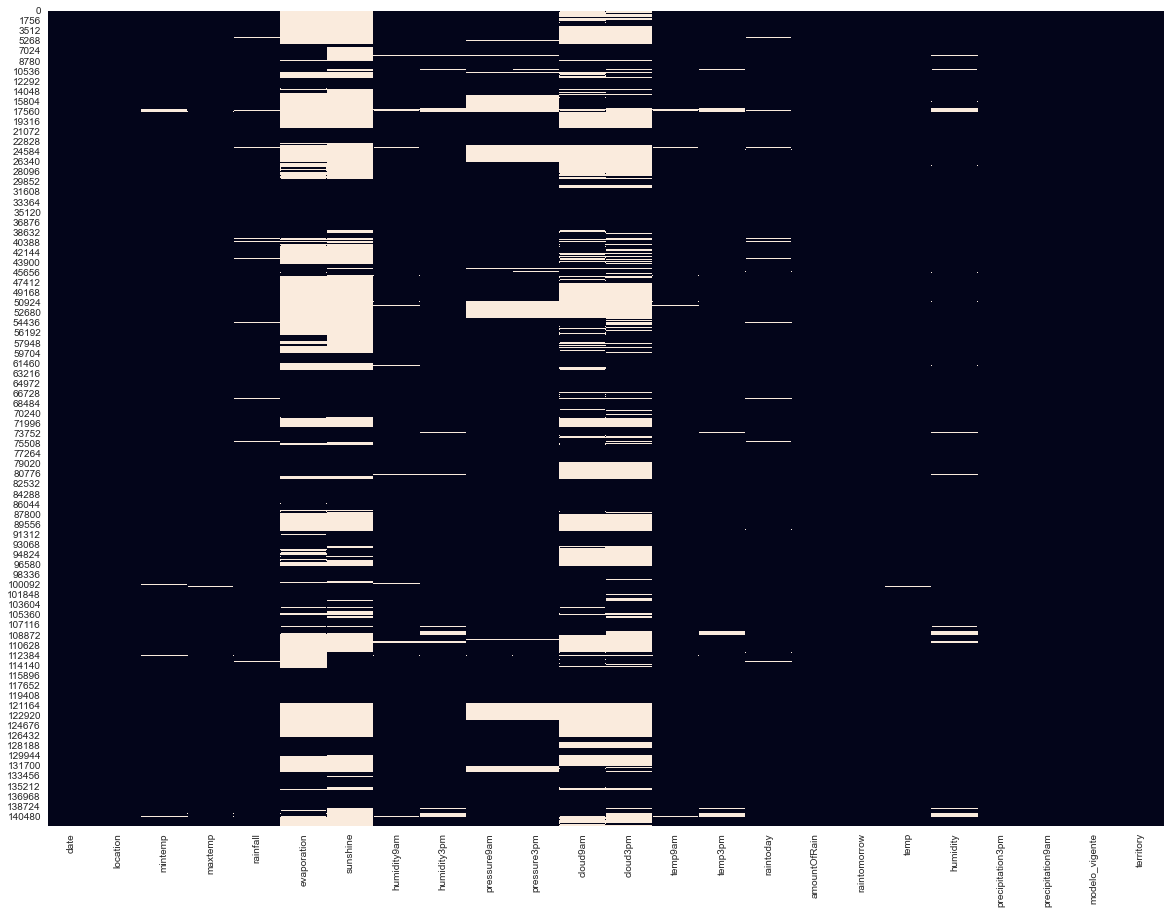

In [13]:
# Checkinig nulls with heatmap
image, axs = plt.subplots(figsize=(20,15))
sns.heatmap(rain.isnull(), cbar=False)

In [14]:
rain.describe().T

,count,mean,std,min,25%,50%,75%,max
mintemp,141556.0,12.186400,6.403283,-8.500000,7.600000,12.000000,16.800000,33.90000
maxtemp,141871.0,23.226784,7.117618,-4.800000,17.900000,22.600000,28.200000,48.10000
rainfall,140787.0,2.349974,8.465173,0.000000,0.000000,0.000000,0.800000,371.00000
evaporation,81350.0,5.469824,4.188537,0.000000,2.600000,4.800000,7.400000,145.00000
sunshine,74377.0,7.624853,3.781525,0.000000,4.900000,8.500000,10.600000,14.50000
humidity9am,140419.0,68.843810,19.051293,0.000000,57.000000,70.000000,83.000000,100.00000
humidity3pm,138583.0,51.482606,20.797772,0.000000,37.000000,52.000000,66.000000,100.00000
pressure9am,128179.0,1017.653758,7.105476,980.500000,1012.900000,1017.600000,1022.400000,1041.00000
pressure3pm,128212.0,1015.258204,7.036677,977.100000,1010.400000,1015.200000,1020.000000,1039.60000
cloud9am,88536.0,4.437189,2.887016,0.000000,1.000000,5.000000,7.000000,9.00000


## 2.2 Data Viz

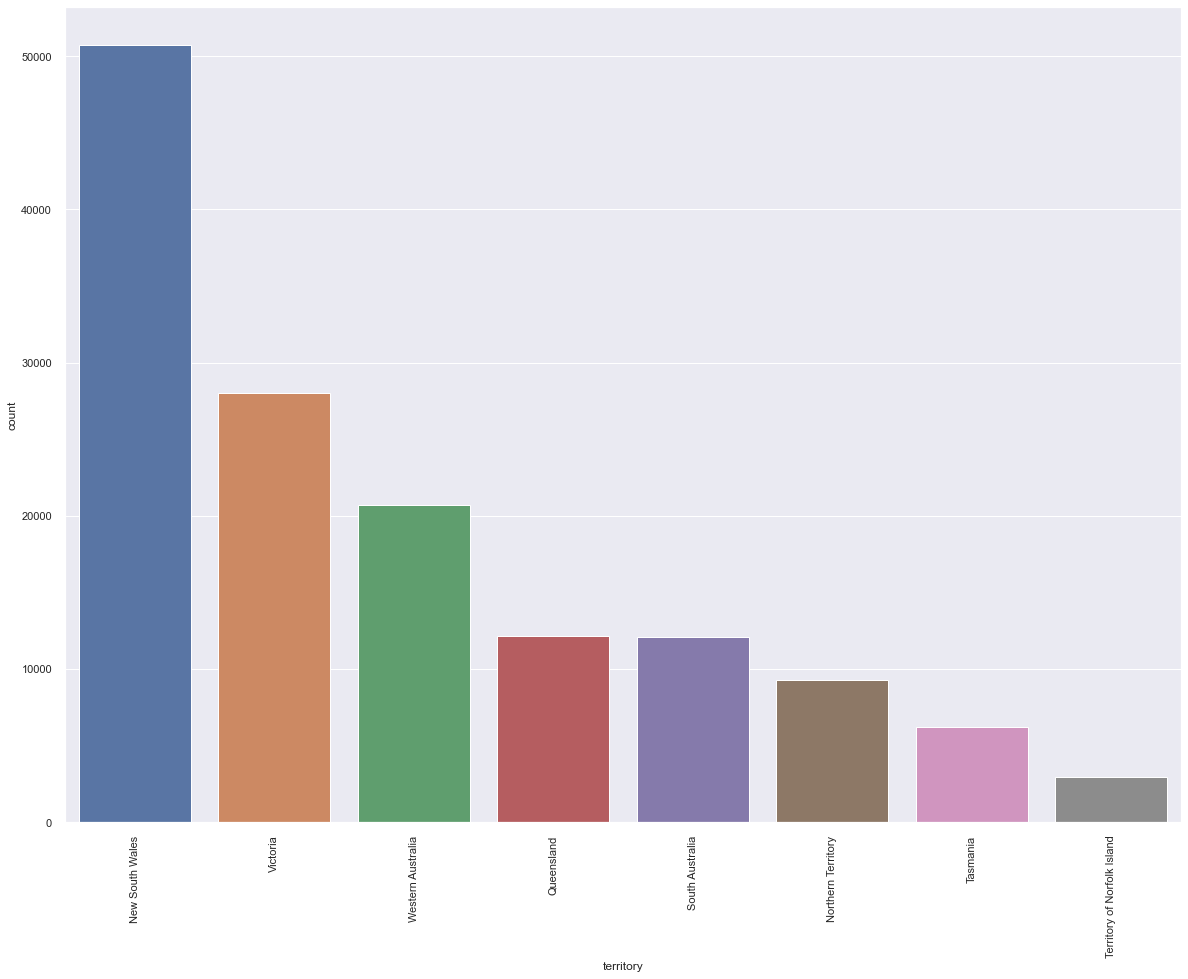

In [15]:
# Count of measurement location by state/territory
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 15))
sns.countplot(rain['territory'], order=rain['territory'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

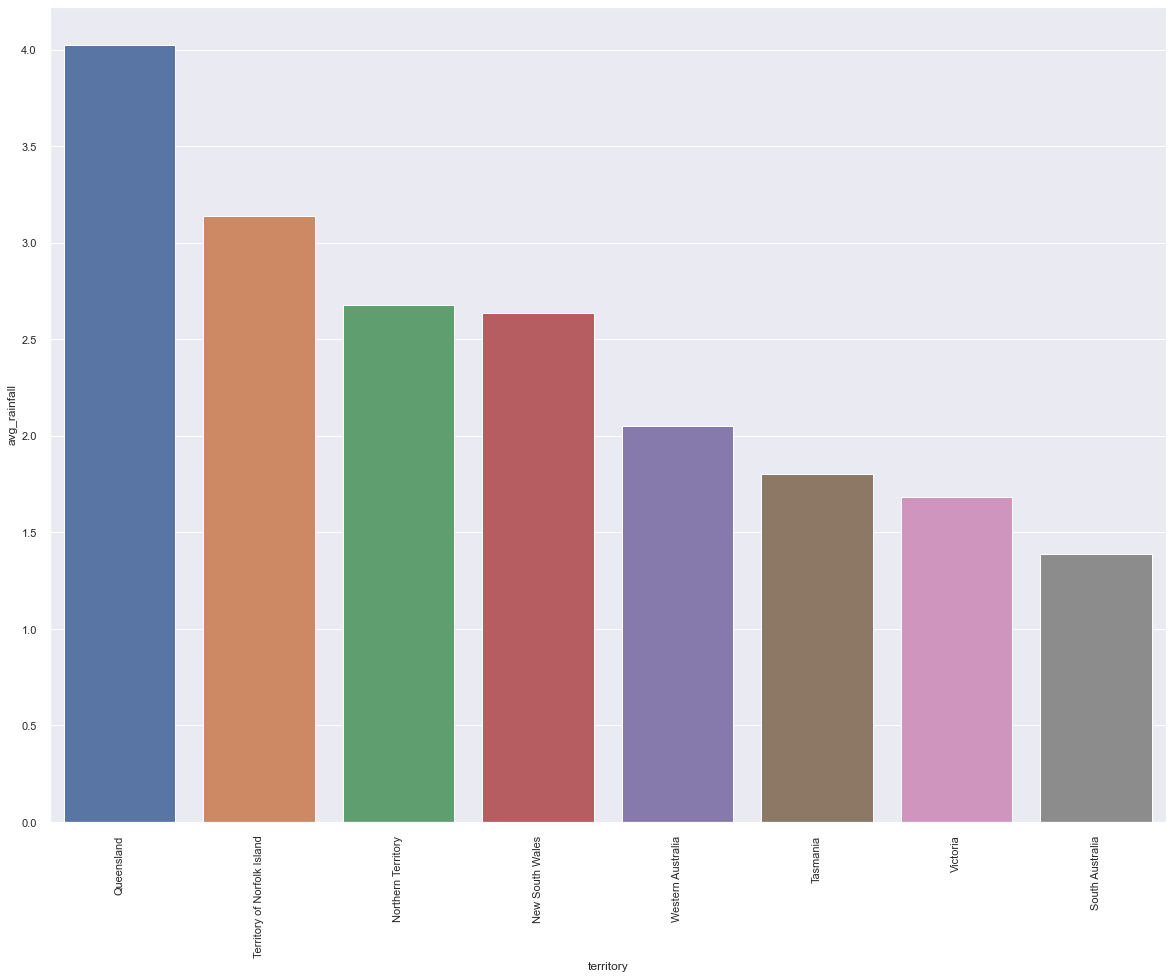

In [16]:
# Average rainfall by state/territory
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 15))
rain_ter = rain.groupby('territory')['rainfall'].agg(avg_rainfall = 'mean').sort_values('avg_rainfall', ascending = False).reset_index()
sns.barplot(rain_ter['territory'], rain_ter['avg_rainfall'])
plt.xticks(rotation=90)
plt.show()

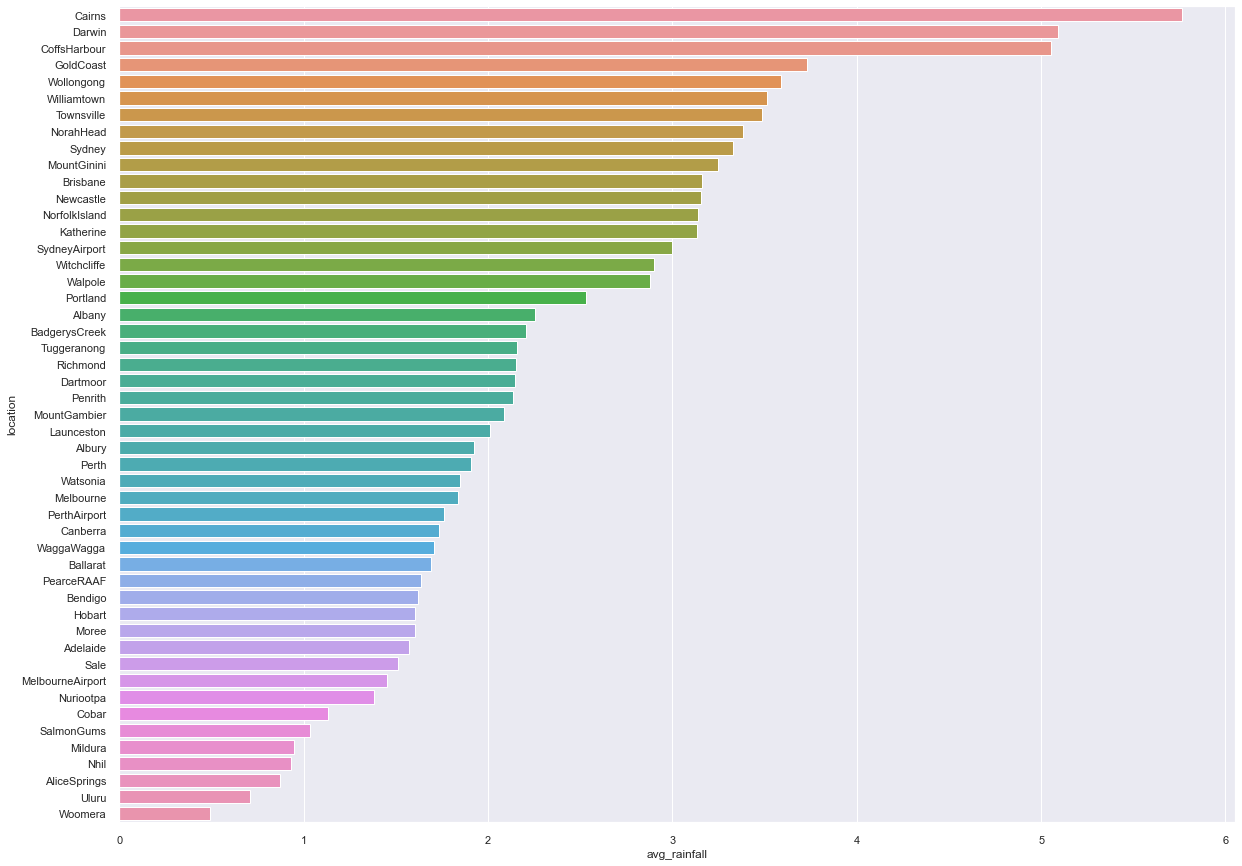

In [17]:
# Average rainfall by measuring location
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 15))
rain_ter = rain.groupby('location')['rainfall'].agg(avg_rainfall = 'mean').sort_values('avg_rainfall', ascending = False).reset_index()
sns.barplot(rain_ter['avg_rainfall'], rain_ter['location'], orient='h')
plt.show()

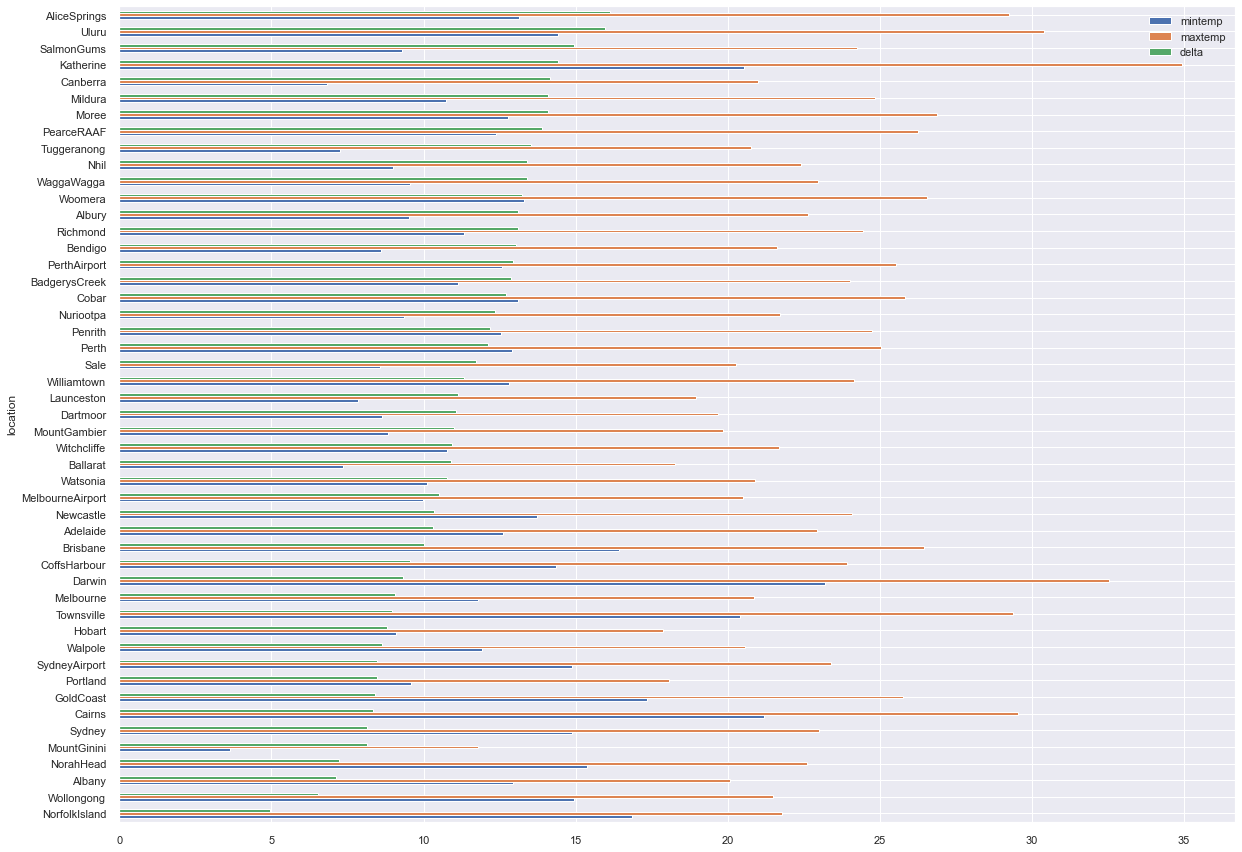

In [18]:
# Thermal amplitude by measuring location
temp_avg = rain.groupby(['location']).mean()[['mintemp', 'maxtemp']]
temp_avg['delta'] = temp_avg['maxtemp'] - temp_avg['mintemp']
temp_avg.sort_values(by='delta', ascending=True).plot(kind='barh', figsize=(20, 15))
plt.show()

In [19]:
# Encoding objects
rain_enc = rain.copy()
cat_f = [x for x in rain_enc.columns if rain_enc[x].dtype == 'object']

for name in cat_f:
    enc = preprocessing.LabelEncoder()
    enc.fit(list(rain_enc[name].values.astype('str')) + list(rain_enc[name].values.astype('str')))
    rain_enc[name] = enc.transform(rain_enc[name].values.astype('str'))

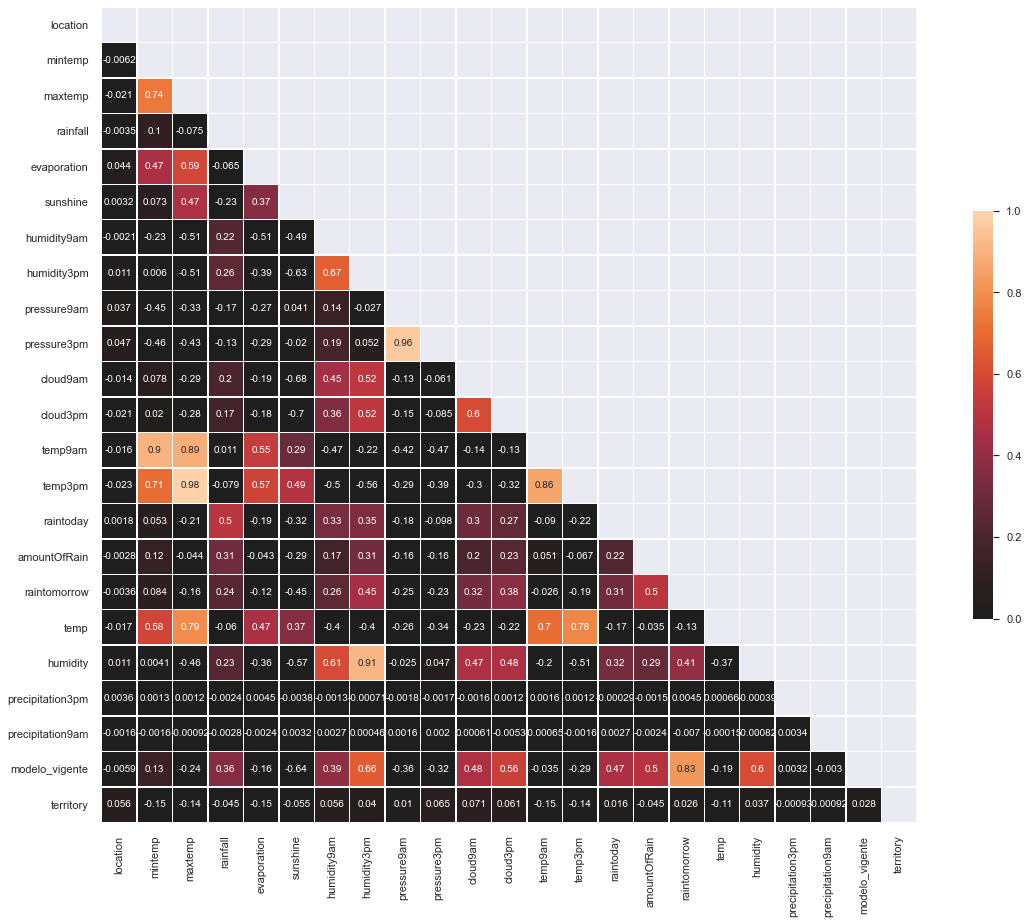

In [20]:
# Investigating correlations
corr = rain_enc.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(10, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, vmin=0, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 10})
plt.show()

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


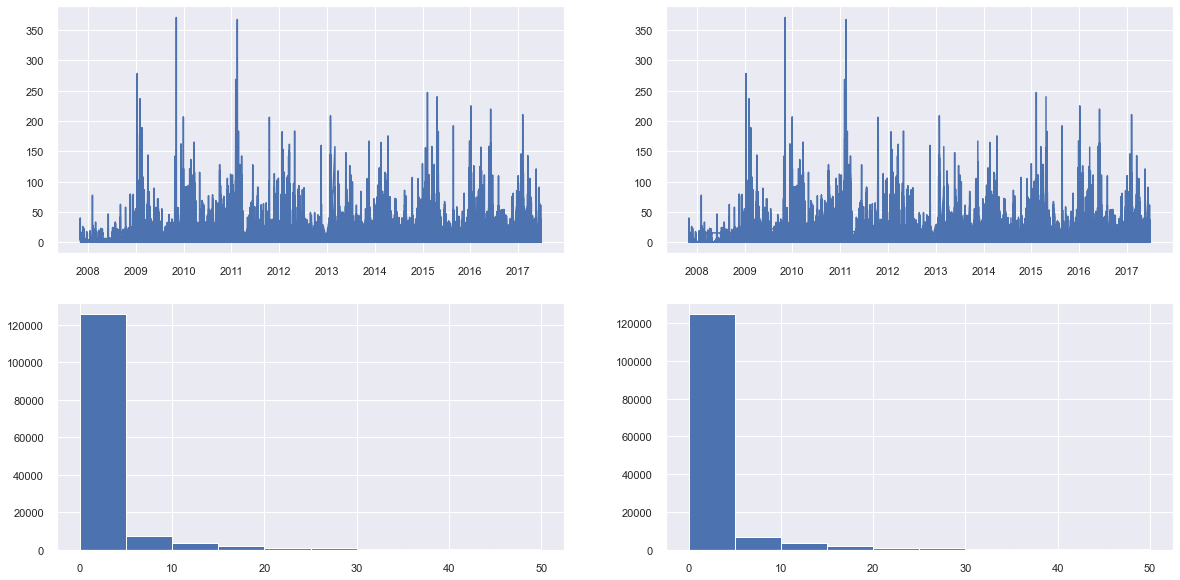

In [21]:
# Investigating variables amountOfRain and rainfall
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0][0].plot(rain['date'], rain['amountOfRain'])
ax[0][1].plot(rain['date'], rain['rainfall'])
ax[1][0].hist(rain['amountOfRain'], range=(0,50))
ax[1][1].hist(rain['rainfall'], range=(0,50))
plt.show()

In [22]:
rain[['amountOfRain', 'rainfall']].describe().T

,count,mean,std,min,25%,50%,75%,max
amountOfRain,142193.0,2.360682,8.477969,0.0,0.0,0.0,0.8,371.0
rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0


In [23]:
rain[['amountOfRain', 'rainfall']].head(15)

,amountOfRain,rainfall
0,0.0,0.6
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.2,1.0
5,0.0,0.2
6,0.0,0.0
7,0.0,0.0
8,1.4,0.0
9,0.0,1.4


The variables **amountOfRain** and **rainfall** are the same. The only difference is that **rainfall** correspondes to the rain in the previous day. Predictions won't be given with the target's day rainfall, therefore we can drop the variable **amountOfRain**.

In [24]:
rain.drop(['amountOfRain'], axis = 1, inplace = True)

# 3. Baseline Model

## 3.1 Aggregating Wind Speed and Direction

In [25]:
wind['date'] = pd.to_datetime(wind['date'])

In [26]:
rain_wind = pd.merge(rain, wind, how = 'left', on =['location', 'date'])

In [27]:
rain_wind['day'] = rain_wind['date'].dt.day
rain_wind['month'] = rain_wind['date'].dt.month
rain_wind['year'] = rain_wind['date'].dt.year

## 3.2 Treating Missing Values

In [28]:
# Establishing threshold for dropping columns
nan = rain_wind.isnull().mean()
drop_cols = []

for num, value in enumerate(nan.values):
    if value > 0.3:
        drop_cols.append(nan.index[num])
drop_cols

['evaporation', 'sunshine', 'cloud9am', 'cloud3pm']

In [29]:
# Dropping columns
rain_wind.drop(drop_cols, axis=1, inplace = True)

In [30]:
rain_wind['pressure9am'].isnull().value_counts(normalize=True)

False    0.900837
True     0.099163
Name: pressure9am, dtype: float64

In [31]:
rain_wind['pressure3pm'].isnull().value_counts(normalize=True)

False    0.901007
True     0.098993
Name: pressure3pm, dtype: float64

In [32]:
rain_wind.groupby('location')[['pressure9am', 'pressure3pm']].describe()

pressure9am                                           \
                       count         mean        std    min       25%   
location                                                                
Adelaide              3541.0  1018.730246   7.410902  982.3  1013.700   
Albany                3435.0  1018.273217   7.233808  989.2  1013.600   
Albury                3467.0  1018.388982   7.424622  989.8  1013.300   
AliceSprings          3483.0  1016.764370   6.381473  997.7  1011.900   
BadgerysCreek         3228.0  1018.449133   7.081191  996.8  1013.875   
Ballarat              3465.0  1017.832266   7.691203  989.4  1012.800   
Bendigo               3477.0  1018.004861   7.517960  989.5  1012.900   
Brisbane              3618.0  1018.269292   5.434825  997.8  1014.600   
Cairns                3402.0  1014.210523   4.113361  994.4  1011.500   
Canberra              3653.0  1018.952669   7.548936  987.4  1013.900   
Cobar                 3410.0  1018.029238   6.501418  991.7  1013.200   
CoffsHarbour          3148.0  1018.246728   6.108517  998.3  1014.100   
Dartmoor              3403.0  1017.928857   8.040674  986.2  1012.700   
Darwin                3652.0  1011.885159   3.308664  996.3  1009.700   
GoldCoast             3423.0  1017.961087   5.430389  999.5  1014.300   
Hobart                3649.0  1014.398054  10.028900  982.2  1007.900   
Katherine             2009.0  1012.806869   3.743957  998.9  1010.200   
Launceston            1882.0  1015.666578   9.238052  985.0  1009.900   
Melbourne             2855.0  1017.664483   7.929645  988.9  1012.600   
MelbourneAirport      3470.0  1018.037320   7.762015  989.7  1013.025   
Mildura               3463.0  1018.763558   7.105829  991.3  1013.800   
Moree                 3315.0  1018.353906   5.951526  999.0  1014.000   
MountGambier          3481.0  1017.875926   8.019843  985.1  1012.800   
MountGinini              0.0          NaN        NaN    NaN       NaN   
Newcastle                0.0          NaN        NaN    NaN       NaN   
Nhil                  2031.0  1018.430675   7.644672  986.9  1013.450   
NorahHead             3378.0  1018.219331   6.783201  996.5  1013.900   
NorfolkIsland         3373.0  1017.677498   5.441781  980.5  1014.300   
Nuriootpa             3454.0  1018.875391   7.223361  982.0  1014.100   
PearceRAAF            3197.0  1017.791711   6.266669  996.9  1013.200   
Penrith                  0.0          NaN        NaN    NaN       NaN   
Perth                 3654.0  1017.842994   6.464813  996.2  1013.200   
PerthAirport          3469.0  1017.945200   6.380311  996.7  1013.300   
Portland              3444.0  1017.619164   8.164912  986.7  1012.300   
Richmond              3391.0  1018.659245   7.088958  997.0  1014.000   
Sale                  3442.0  1017.790093   8.086027  989.3  1012.600   
SalmonGums               0.0          NaN        NaN    NaN       NaN   
Sydney                3777.0  1018.324940   7.063046  986.7  1013.700   
SydneyAirport         3454.0  1018.324349   7.035390  996.3  1013.700   
Townsville            3489.0  1015.212382   4.515164  994.3  1012.100   
Tuggeranong           3440.0  1018.516105   7.630198  992.8  1013.300   
Uluru                 1976.0  1017.071407   6.450650  994.6  1012.300   
WaggaWagga            3404.0  1018.603378   7.115451  991.5  1013.700   
Walpole               3263.0  1017.833742   7.078007  988.9  1013.300   
Watsonia              3455.0  1017.999045   7.777364  989.7  1012.900   
Williamtown           2976.0  1018.383669   6.646727  997.8  1014.100   
Witchcliffe           3275.0  1018.479664   6.651122  992.3  1014.200   
Wollongong            3384.0  1018.066312   7.270711  994.0  1013.400   
Woomera               3430.0  1018.697026   6.750472  997.5  1014.000   

                                            pressure3pm               \
                      50%       75%     max       count         mean   
location                                                               
Adel

In [33]:
# If we drop locations withou preassure measure, what % of records would we lose?
locations = ['MountGinini', 'Newcastle', 'Penrith', 'SalmonGums']
num_records = []

for local in locations:
    num_records.append(rain['location'].value_counts()[local])
sum(num_records)/rain_wind.shape[0]

0.07166668694414366

In [34]:
# Dropping rows with missing pressure information
locations = ['MountGinini', 'Newcastle', 'Penrith', 'SalmonGums']

rain_wind = rain_wind.query(f"location != {locations}")

In [35]:
# Checking duplicated rows
rain_wind.duplicated().sum()

20377

In [36]:
# Dropping duplicated rows
rain_wind.drop_duplicates(inplace = True)

In [37]:
# Dropping remaining rows with missing values
rain_wind = rain_wind.dropna()

In [38]:
rain_wind.drop(columns = ['wind_gustdir', 'wind_gustspeed'], inplace = True)

In [39]:
rain_wind.isnull().sum()

date                0
location            0
mintemp             0
maxtemp             0
rainfall            0
humidity9am         0
humidity3pm         0
pressure9am         0
pressure3pm         0
temp9am             0
temp3pm             0
raintoday           0
raintomorrow        0
temp                0
humidity            0
precipitation3pm    0
precipitation9am    0
modelo_vigente      0
territory           0
wind_dir9am         0
wind_dir3pm         0
wind_speed9am       0
wind_speed3pm       0
day                 0
month               0
year                0
dtype: int64

## 3.3 Treating Objects

In [40]:
rain_wind['raintoday'] = rain_wind['raintoday'].apply(lambda x: 0 if x == 'No' else 1)
rain_wind['raintomorrow'] = rain_wind['raintomorrow'].apply(lambda x: 0 if x == 'No' else 1)

In [41]:
rain_wind['wind_speed9am'] = rain_wind['wind_speed9am'].astype('int32')
rain_wind['wind_speed3pm'] = rain_wind['wind_speed3pm'].astype('int32')

In [42]:
rain_wind = pd.concat([rain_wind, pd.get_dummies(rain_wind['wind_dir9am'], prefix = 'wind_dir9am')], axis=1)

In [43]:
rain_wind = pd.concat([rain_wind, pd.get_dummies(rain_wind['wind_dir3pm'], prefix = 'wind_dir3pm')], axis=1)

## 3.4 Model

### 3.4.1 Logistic Regression

In [44]:
model = LogisticRegression(n_jobs = -1)

In [45]:
# Defining target variable
y = rain_wind['raintomorrow']

In [46]:
# Defining feature
X = rain_wind[['mintemp', 'maxtemp', 'rainfall', 
            'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'temp9am', 'temp3pm','temp9am', 
            'temp3pm', 'temp', 'humidity', 'precipitation3pm', 
            'precipitation9am','wind_speed9am', 'wind_speed3pm',
            'wind_dir9am_E', 'wind_dir9am_ENE', 'wind_dir9am_ESE', 'wind_dir9am_N',
            'wind_dir9am_NE', 'wind_dir9am_NNE', 'wind_dir9am_NNW',
            'wind_dir9am_NW', 'wind_dir9am_S', 'wind_dir9am_SE', 'wind_dir9am_SSE',
            'wind_dir9am_SSW', 'wind_dir9am_SW', 'wind_dir9am_W', 'wind_dir9am_WNW',
            'wind_dir9am_WSW', 'wind_dir3pm_E', 'wind_dir3pm_ENE',
            'wind_dir3pm_ESE', 'wind_dir3pm_N', 'wind_dir3pm_NE', 'wind_dir3pm_NNE',
            'wind_dir3pm_NNW', 'wind_dir3pm_NW', 'wind_dir3pm_S', 'wind_dir3pm_SE',
            'wind_dir3pm_SSE', 'wind_dir3pm_SSW', 'wind_dir3pm_SW', 'wind_dir3pm_W',
            'wind_dir3pm_WNW', 'wind_dir3pm_WSW']]

In [47]:
# Standardizing data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = X.columns)

In [48]:
# Spliting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state = 42)

In [49]:
# Trainning model
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 3.4.2 Model Evaluation

#### 3.4.2.1 Model Score

In [50]:
baseline_score = model.score(X_test, y_test)
baseline_score

0.8405355624822896

#### 3.4.2.2 Confusion Matrix

In [51]:
confusion_matrix(y_test, model.predict(X_test))

array([[20791,  1104],
       [ 3398,  2939]])

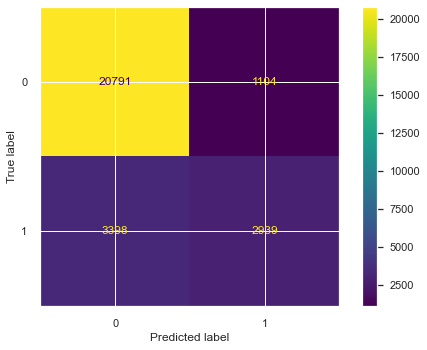

In [52]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

#### 3.4.2.3 Precision vs. Recall

In [53]:
baseline_precision = precision_score(y_test, model.predict(X_test))
baseline_precision

0.7269354439772446

In [54]:
baseline_recall = recall_score(y_test, model.predict(X_test))
baseline_recall

0.4637841249802746

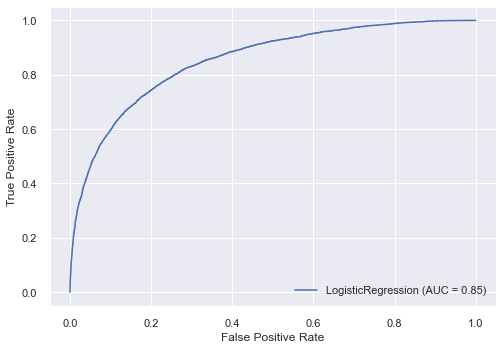

In [55]:
plot_roc_curve(model, X_test, y_test)

In [56]:
list(zip(list(X.columns), list(model.coef_[0])))

[('mintemp', 0.39868803635242067),
 ('maxtemp', 0.46383982478076713),
 ('rainfall', 0.2453276497784475),
 ('humidity9am', 0.044348008957749804),
 ('humidity3pm', 1.2468409431422733),
 ('pressure9am', 0.8222250259520264),
 ('pressure3pm', -1.3859627506797823),
 ('temp9am', -0.10301721774785368),
 ('temp3pm', -0.41157267202291786),
 ('temp9am', -0.10301721774785368),
 ('temp3pm', -0.41157267202291786),
 ('temp', -0.0045129070564431445),
 ('humidity', -0.005574339737748304),
 ('precipitation3pm', 0.013577942524685286),
 ('precipitation9am', -0.02678700058527275),
 ('wind_speed9am', 0.1519668991217197),
 ('wind_speed3pm', 0.03146711854749528),
 ('wind_dir9am_E', -0.00273322443275754),
 ('wind_dir9am_ENE', 0.04524739148917663),
 ('wind_dir9am_ESE', -0.04046686894222941),
 ('wind_dir9am_N', 0.06066800996211731),
 ('wind_dir9am_NE', 0.06804107290250247),
 ('wind_dir9am_NNE', 0.09535485736226167),
 ('wind_dir9am_NNW', -0.023162739674613395),
 ('wind_dir9am_NW', -0.04131183131864939),
 ('wind_d

#### 3.4.2.4 Function to concatenate model results

In [57]:
def scores(Column, score, precision, recall):
    """
    This function creates a dataframe with model results (score, precision and recall).
    Each time this function is called, it adds a column to the dataframe. It creates a data frame to easily
    compare models results.
    """
    
    df = pd.DataFrame({Column : [score, precision, recall]}, index = ['score', 'precision', 'recall'])
    x = pd.concat([rain_scores, df], axis = 1)
    
    return x

In [58]:
rain_scores = pd.DataFrame({'Baseline (Log. Regression)' : [baseline_score, baseline_precision, baseline_recall]}, index = ['score', 'precision', 'recall'])
rain_scores

,Baseline (Log. Regression)
score,0.840536
precision,0.726935
recall,0.463784


# 4. Decision Tree

In [59]:
y = rain_wind['raintomorrow']
X = rain_wind.drop(columns = ['location','raintomorrow', 'raintoday','date', 'territory', 'wind_dir9am', 'wind_dir3pm', 'modelo_vigente', 'humidity'])

In [60]:
# Spliting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [61]:
model = DecisionTreeClassifier(max_depth = 5, ccp_alpha = 0.001, random_state = 42)

In [62]:
# Cross Validation
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

mean_results = []

for i in scoring:
    results = cross_val_score(model, X_train, y_train, cv = KFold(10, shuffle =True), scoring = i, n_jobs = -1)
    
    mean_results.append([np.mean(results), np.std(results)])
    
pd.DataFrame(mean_results, columns = ['mean_dt1', 'std_dt1'], index = scoring)        

,mean_dt1,std_dt1
accuracy,0.833617,0.005693
precision,0.723867,0.034745
recall,0.382561,0.025662
roc_auc,0.815474,0.004078


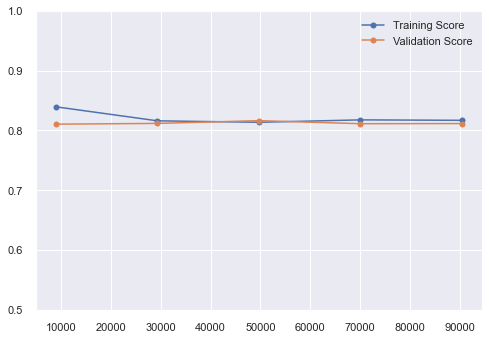

In [63]:
# Learning Curve
curves = learning_curve(model, X, y, scoring = 'roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis = 1), '-o', label = 'Training Score')
plt.plot(train_sizes, test_scores.mean(axis = 1), '-o', label = 'Validation Score');
plt.ylim([0.5, 1])
plt.legend()
plt.show()

In [64]:
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

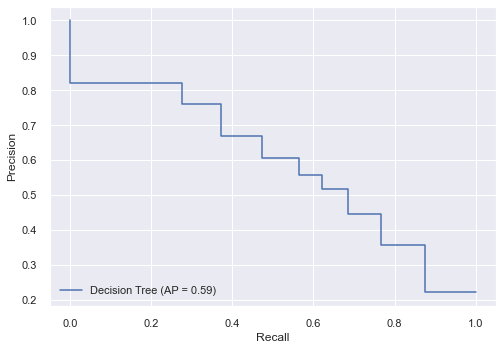

In [65]:
plot_precision_recall_curve(model, X_test, y_test, name = 'Decision Tree')

In [66]:
score = model.score(X_test, y_test)

In [67]:
score_recall = recall_score(y_test, model.predict(X_test))
score_recall

0.37130295763389287

In [68]:
precision_recall = precision_score(y_test, model.predict(X_test))
precision_recall

0.7608517608517609

## 4.1 Model Summary

In [69]:
rain_scores = scores('Decision Tree', score, precision_recall, score_recall)
rain_scores

,Baseline (Log. Regression),Decision Tree
score,0.840536,0.834846
precision,0.726935,0.760852
recall,0.463784,0.371303


## 4.2 Plot Decision Tree

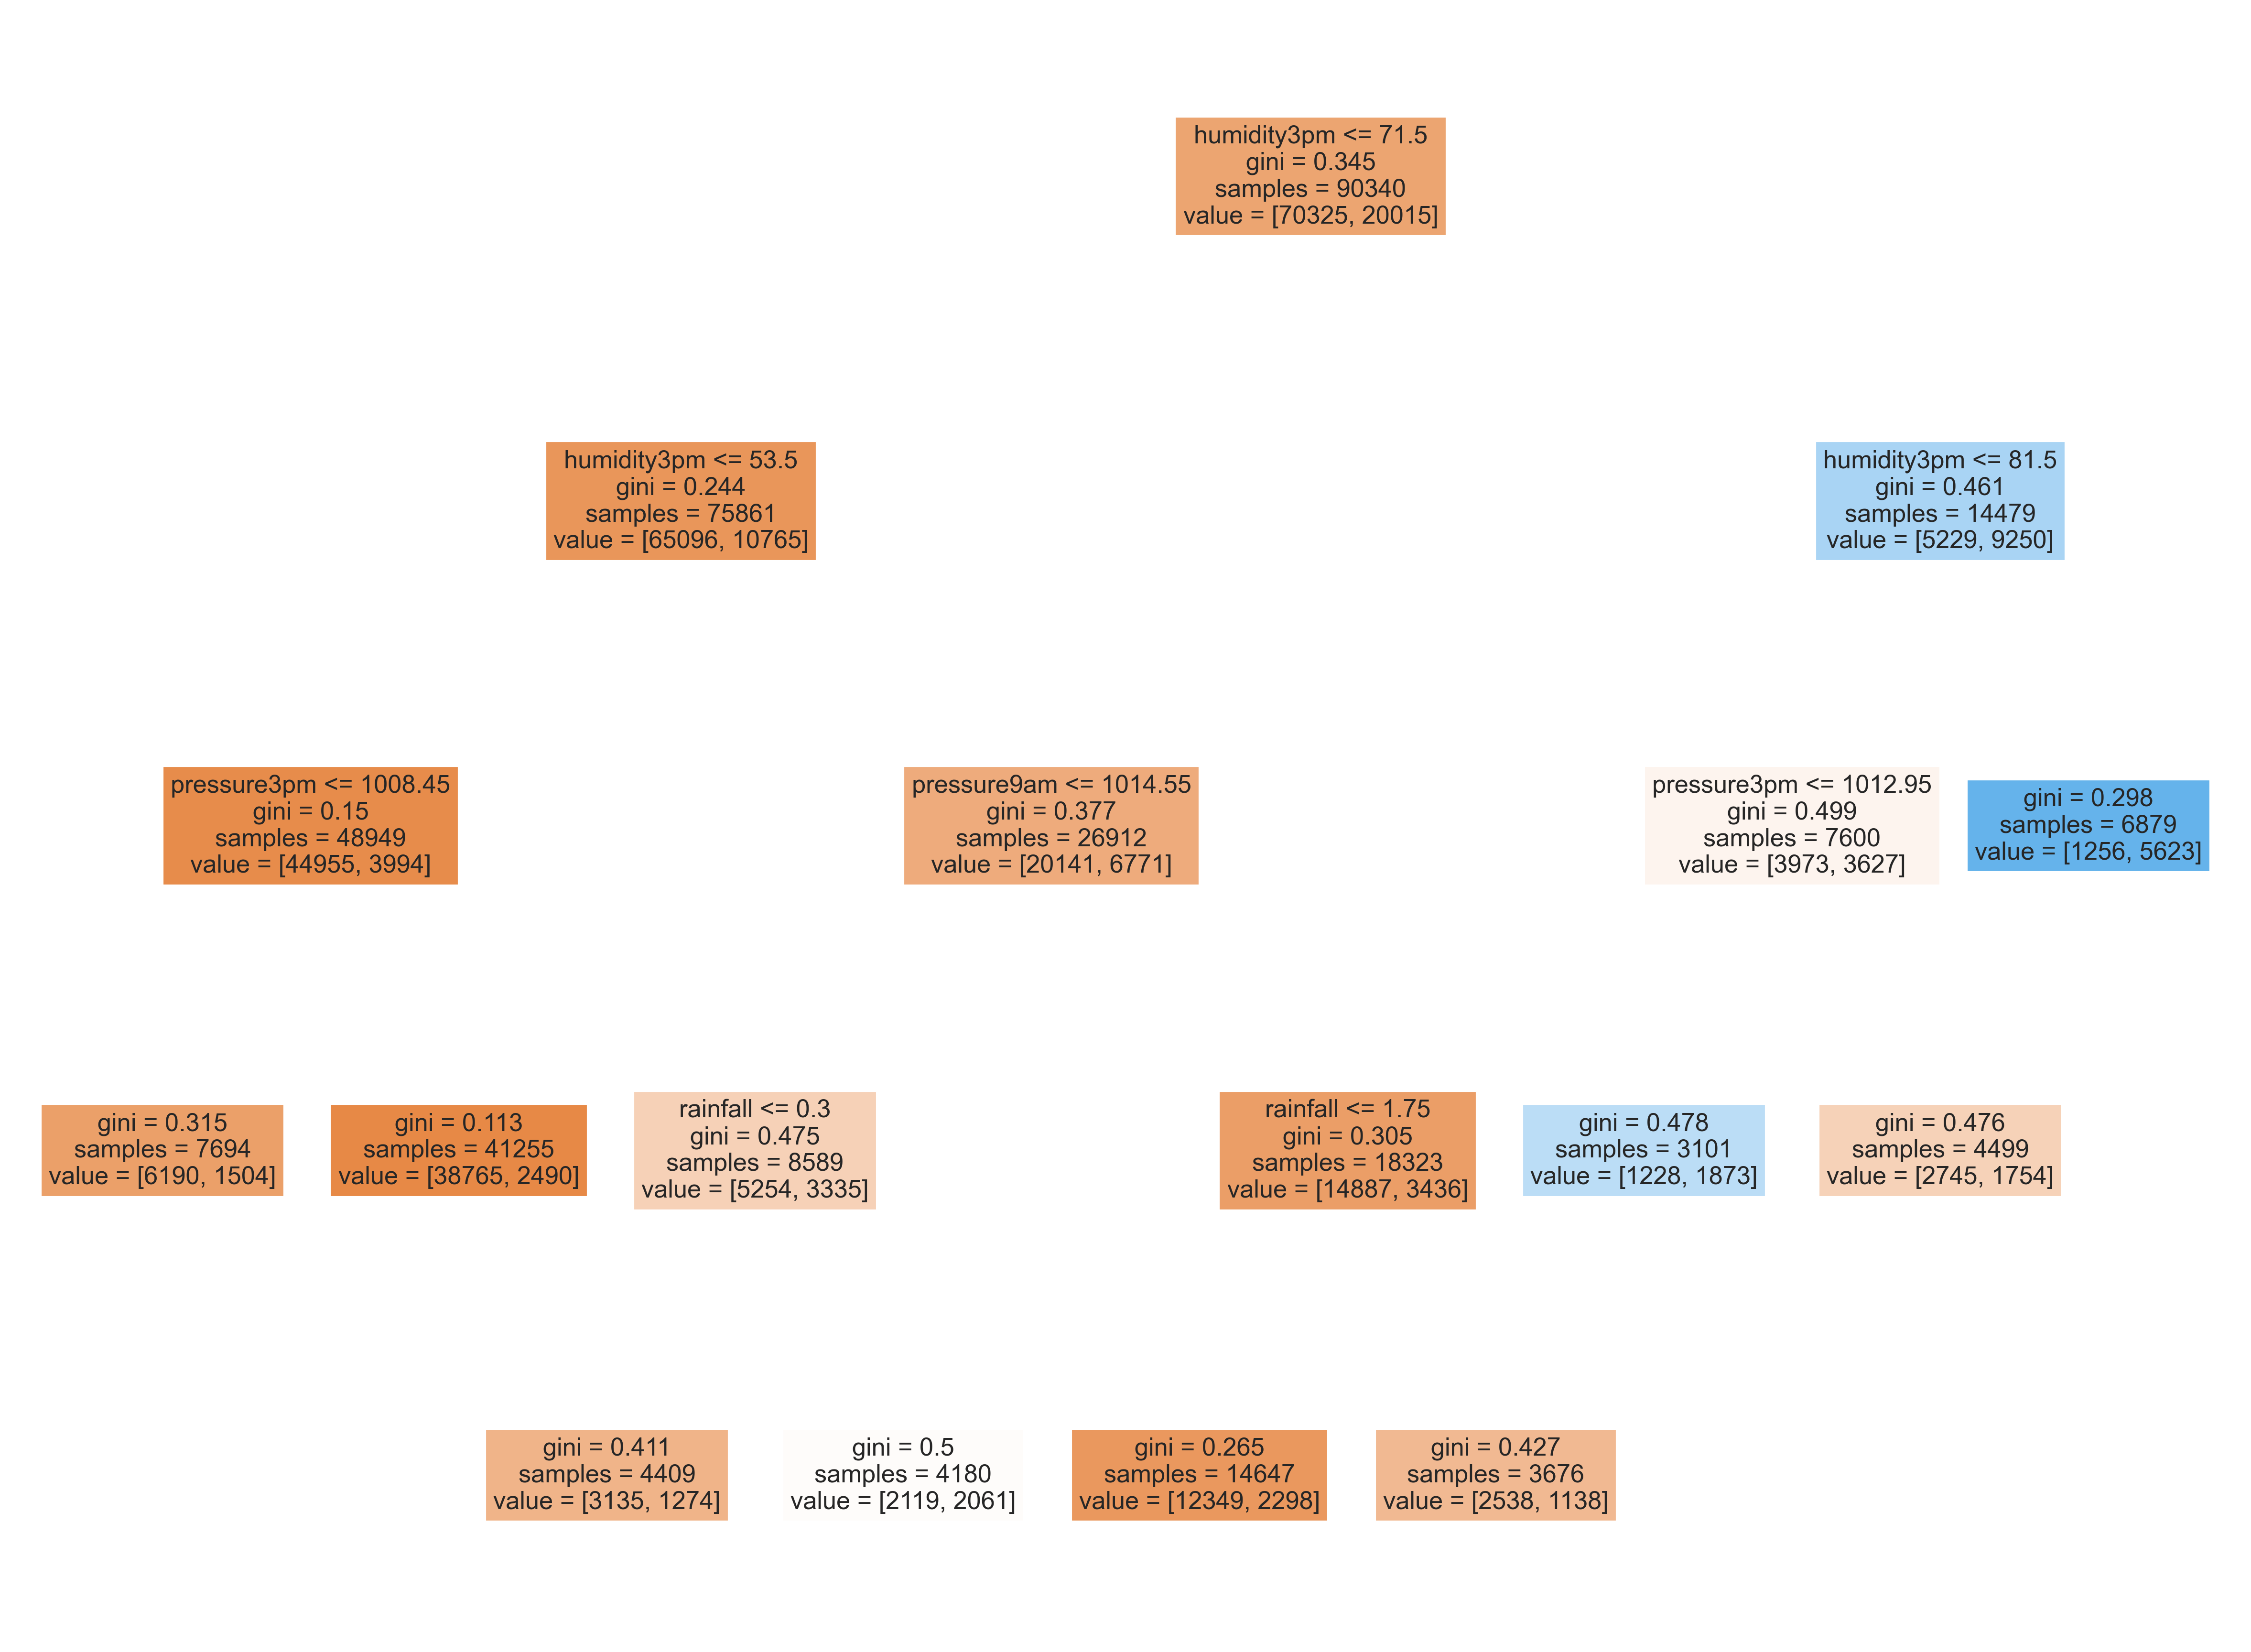

In [70]:
fig, axs = plt.subplots(1, 1, figsize = (20, 15), dpi=300)
plot_tree(model, filled = True, feature_names = X.columns)
plt.show()

In [71]:
pd.DataFrame(zip(X.columns, model.feature_importances_)).sort_values(1, ascending = False).head()

,0,1
4,humidity3pm,0.868062
5,pressure9am,0.052163
6,pressure3pm,0.044830
2,rainfall,0.034944
0,mintemp,0.000000


# 5. Random Forest

In [72]:
y = rain_wind['raintomorrow']
X = rain_wind.drop(columns = ['location','raintomorrow', 'raintoday','date', 'territory', 'wind_dir9am', 'wind_dir3pm', 'modelo_vigente', 'humidity'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [74]:
model = RandomForestClassifier(max_depth = 5, n_estimators = 200, n_jobs = -1)

In [75]:
# Cross Validation
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

mean_results = []

for i in scoring:
    results = cross_val_score(model, X_train, y_train, cv = KFold(10, shuffle =True), scoring = i, n_jobs = -1)
    
    mean_results.append([np.mean(results), np.std(results)])
    
pd.DataFrame(mean_results, columns = ['mean_dt1', 'std_dt1'], index = scoring)        

,mean_dt1,std_dt1
accuracy,0.832522,0.002624
precision,0.823685,0.014624
recall,0.316921,0.012343
roc_auc,0.842136,0.004822


In [76]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [77]:
score = model.score(X_test, y_test)
score

0.8320123976090326

In [78]:
score_recall = recall_score(y_test, model.predict(X_test))
score_recall

0.3049560351718625

In [79]:
score_precision = precision_score(y_test, model.predict(X_test))
score_precision

0.8284473398479913

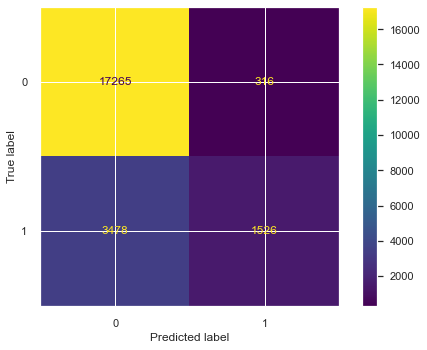

In [80]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

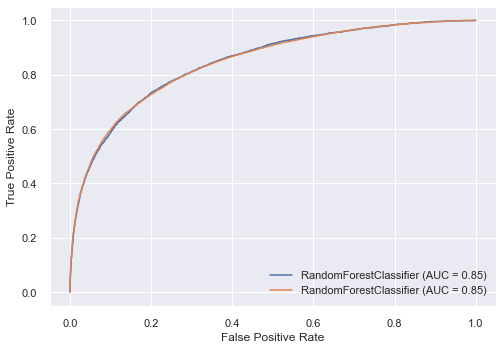

In [81]:
fig, ax = plt.subplots()

plot_roc_curve(model, X_test, y_test, ax=ax)
plot_roc_curve(model, X_train, y_train, ax=ax)

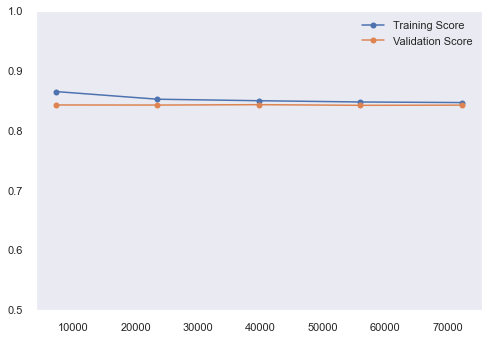

In [82]:
curves = learning_curve(model, X_train, y_train, scoring = 'roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Validation Score')
plt.ylim([0.5, 1])
plt.legend()
plt.grid()

## 5.1 Model Summary

In [83]:
rain_scores = scores('Random Forest', score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Decision Tree,Random Forest
score,0.840536,0.834846,0.832012
precision,0.726935,0.760852,0.828447
recall,0.463784,0.371303,0.304956


In [84]:
pd.DataFrame(zip(X.columns, model.feature_importances_)).sort_values(1, ascending = False).head()

,0,1
4,humidity3pm,0.372758
2,rainfall,0.189055
3,humidity9am,0.099760
6,pressure3pm,0.089172
5,pressure9am,0.078488


# 6. XGBoost

In [85]:
model = XGBClassifier(max_depth = 1, n_estimators = 50, colsample_bytree = 0.7, n_jobs = -1)

In [86]:
# Cross Validation
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

mean_results = []

for i in scoring:
    results = cross_val_score(model, X_train, y_train, cv = KFold(10, shuffle =True), scoring = i, n_jobs = -1)
    
    mean_results.append([np.mean(results), np.std(results)])
    
pd.DataFrame(mean_results, columns = ['mean_dt1', 'std_dt1'], index = scoring)        

,mean_dt1,std_dt1
accuracy,0.841233,0.003414
precision,0.739938,0.016704
recall,0.438052,0.013682
roc_auc,0.851686,0.006305


In [87]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
score = model.score(X_test, y_test)
score

0.841841930484835

In [89]:
score_recall = recall_score(y_test, model.predict(X_test))
score_recall

0.43764988009592326

In [90]:
score_precision = precision_score(y_test, model.predict(X_test))
score_precision

0.742876526458616

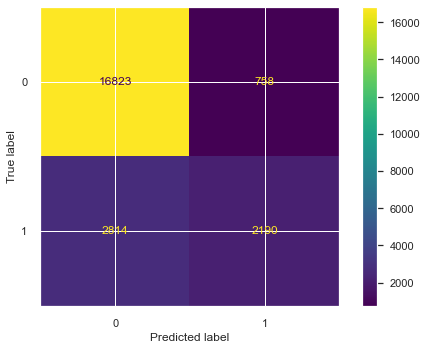

In [91]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

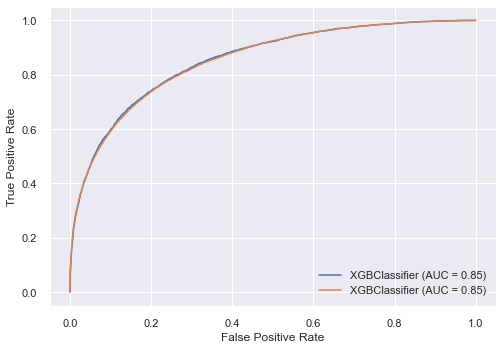

In [92]:
fig, ax = plt.subplots()

plot_roc_curve(model, X_test, y_test, ax=ax)
plot_roc_curve(model, X_train, y_train, ax=ax)

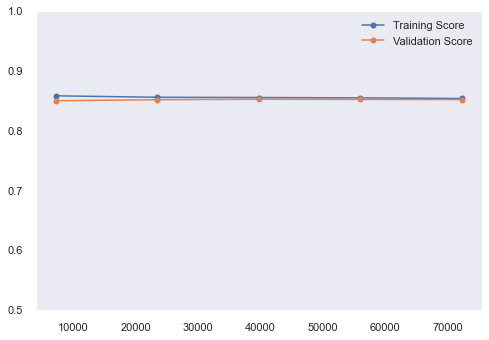

In [93]:
curves = learning_curve(model, X_train, y_train, scoring = 'roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Validation Score')
plt.ylim([0.5, 1])
plt.legend()
plt.grid()

## 6.1 Model Summary

In [94]:
rain_scores = scores('XGBoost', score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Decision Tree,Random Forest,XGBoost
score,0.840536,0.834846,0.832012,0.841842
precision,0.726935,0.760852,0.828447,0.742877
recall,0.463784,0.371303,0.304956,0.437650


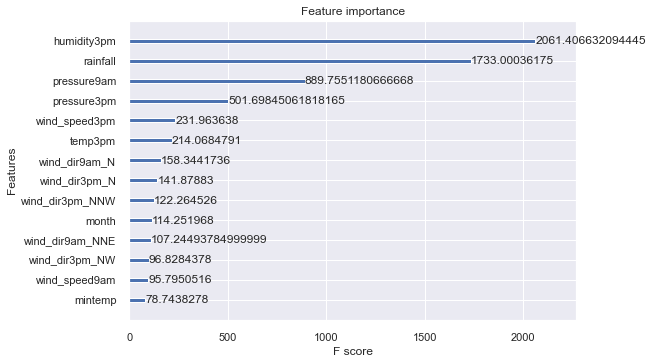

In [95]:
from xgboost import plot_importance

plot_importance(model, importance_type = 'gain')

# 7. KNN

In [96]:
y = rain_wind['raintomorrow']
X = rain_wind.drop(columns = ['location','raintomorrow', 'raintoday','date', 'territory', 'wind_dir9am', 'wind_dir3pm', 'modelo_vigente', 'humidity'])

In [97]:
model = KNeighborsClassifier(n_neighbors = 75, p = 1, n_jobs = -1)

In [98]:
# Cross Validation
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

mean_results = []

for i in scoring:
    results = cross_val_score(model, X_train, y_train, cv = KFold(10, shuffle =True), scoring = i, n_jobs = -1)
    
    mean_results.append([np.mean(results), np.std(results)])
    
pd.DataFrame(mean_results, columns = ['mean_dt1', 'std_dt1'], index = scoring)        

,mean_dt1,std_dt1
accuracy,0.844797,0.003017
precision,0.788720,0.016726
recall,0.409876,0.009015
roc_auc,0.861021,0.004427


In [99]:
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=75, p=1,
                     weights='uniform')

In [100]:
score = model.score(X_test, y_test)
score

0.8446313925171574

In [102]:
score_recall = recall_score(y_test, model.predict(X_test))
score_recall

0.41426858513189446

In [103]:
precision_recall = precision_score(y_test, model.predict(X_test))
precision_recall

0.7819690682761222

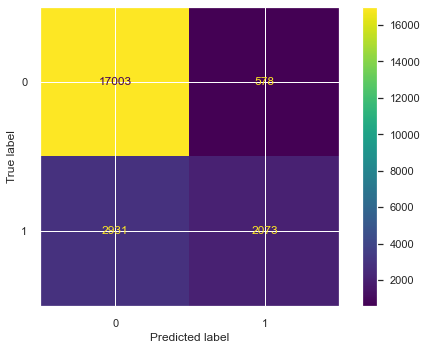

In [104]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

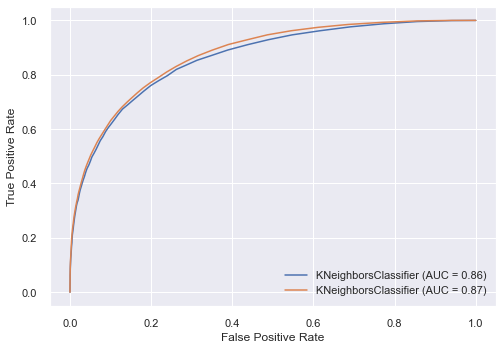

In [105]:
fig, ax = plt.subplots()

plot_roc_curve(model, X_test, y_test, ax=ax)
plot_roc_curve(model, X_train, y_train, ax=ax)

## 7.1 Model Summary

In [107]:
rain_scores = scores('KNN', score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Decision Tree,Random Forest,XGBoost,KNN
score,0.840536,0.834846,0.832012,0.841842,0.844631
precision,0.726935,0.760852,0.828447,0.742877,0.742877
recall,0.463784,0.371303,0.304956,0.437650,0.414269
